In [ ]:
# --- Core Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Display Settings ---
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

# --- Load Data ---
# Change the path to where your file is!
DATA_PATH = "combined_ge15days_official.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["date"])

print(f"Data shape: {df.shape}")
print("\nColumns:", list(df.columns))
print("\nSample rows:")
display(df.head())

# Quick null check
print("\nMissing values per column:\n", df.isnull().sum())


In [2]:
# Number of unique packages
n_packages = df['MAILITM_FID'].nunique()
print(f"Unique packages: {n_packages:,}")

# Unique event types
event_counts = df['EVENT_TYPE_NM'].value_counts()
print("\nEvent type frequencies:\n", event_counts)

# List of all event types (in order of frequency)
print("\nEvent types (sorted):\n", event_counts.index.tolist())

# Date range check
print("\nEarliest event date:", df['date'].min())
print("Latest event date:", df['date'].max())

# Number of rows per package (distribution)
row_dist = df.groupby('MAILITM_FID').size().describe(percentiles=[.5, .75, .9, .99])
print("\nEvent rows per package (describe):\n", row_dist)


Unique packages: 3,048,080

Event type frequencies:
 EVENT_TYPE_NM
Recevoir envoi au bureau de livraison (Ent)                    6703810
Expédier envoi à adresse nationale (Ent)                       4977810
Expédier envoi à adresse nationale (Srt)                       4574729
Recevoir envoi au bureau d'échange (Ent)                       3171717
Insérer envoi dans sac (Srt)                                   2885480
Vaine tentative de livraison d'envoi (Ent)                     2879557
Livraison d'envoi (Ent)                                        2728635
Expédition d'envoi à l'étranger (EDI-reçu)                     2723907
Transmettre envoi à l'agent de livraison (Ent)                 1752347
Réception d'envoi du client (Srt)                              1741234
Enregistrer détails d'envoi au bureau d'échange (Srt)           290829
Recevoir envoi au bureau d'échange (Srt)                        100261
Expédier envoi à la douane (Ent)                                 45737
Renvoyer e

In [3]:
# --- Define principal event sets ---
main_events_delivered = [
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    "Livraison d'envoi (Ent)"
]

main_events_failed = [
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    "Vaine tentative de livraison d'envoi (Ent)"
]

total_packages = df['MAILITM_FID'].nunique()

# --- Find packages with ALL delivered events ---
grouped = df.groupby('MAILITM_FID')['EVENT_TYPE_NM'].apply(set)

delivered_mask = grouped.apply(lambda s: all(e in s for e in main_events_delivered))
failed_mask = grouped.apply(lambda s: all(e in s for e in main_events_failed))

delivered_ids = set(grouped[delivered_mask].index)
failed_ids = set(grouped[failed_mask].index)

# --- Compute stats ---
n_delivered = len(delivered_ids)
n_failed = len(failed_ids)
n_both = len(delivered_ids & failed_ids)
n_either = len(delivered_ids | failed_ids)

print(f"Total packages: {total_packages:,}")
print(f"Delivered main road: {n_delivered:,} ({n_delivered/total_packages:.2%})")
print(f"Failed main road: {n_failed:,} ({n_failed/total_packages:.2%})")
print(f"Both delivered and failed events: {n_both:,} ({n_both/total_packages:.2%})")
print(f"Either delivered or failed events: {n_either:,} ({n_either/total_packages:.2%})")

Total packages: 3,048,080
Delivered main road: 2,610,302 (85.64%)
Failed main road: 2,045,825 (67.12%)
Both delivered and failed events: 1,803,755 (59.18%)
Either delivered or failed events: 2,852,372 (93.58%)


In [4]:
# Side-by-side breakdown table
delivered_only = delivered_ids - failed_ids
failed_only = failed_ids - delivered_ids
both = delivered_ids & failed_ids
neither = set(grouped.index) - (delivered_ids | failed_ids)

def percent(n):
    return f"{n:,} ({n/total_packages:.2%})"

print("Breakdown of package main road outcomes:\n")
print(f"Delivered only: {percent(len(delivered_only))}")
print(f"Failed only: {percent(len(failed_only))}")
print(f"Both delivered and failed: {percent(len(both))}")
print(f"Neither: {percent(len(neither))}")

# For further steps, you can easily get these package ID sets.


Breakdown of package main road outcomes:

Delivered only: 806,547 (26.46%)
Failed only: 242,070 (7.94%)
Both delivered and failed: 1,803,755 (59.18%)
Neither: 195,708 (6.42%)


In [5]:
# Helper: get a dict of group names and their sets of package IDs
groups = {
    'Delivered only': delivered_only,
    'Failed only': failed_only,
    'Both': both,
    'Neither': neither
}

profile_results = {}

for name, ids in groups.items():
    print(f"\n==== {name} ({len(ids):,} packages) ====")
    mask = df['MAILITM_FID'].isin(ids)
    group_df = df[mask]
    
    # 1. Sequence length per package
    seq_lengths = group_df.groupby('MAILITM_FID').size()
    print("  - Event sequence length (mean/median/min/max):",
          round(seq_lengths.mean(),2), "/", seq_lengths.median(), "/", seq_lengths.min(), "/", seq_lengths.max())
    
    # 2. Most common last event
    last_events = (
        group_df.sort_values(['MAILITM_FID', 'date'])
        .groupby('MAILITM_FID')
        .tail(1)
    )
    most_common_last = last_events['EVENT_TYPE_NM'].value_counts().head(5)
    print("  - Top 5 last events:\n", most_common_last)
    
    # 3. Top locations for last event
    top_locs = last_events['établissement_postal'].value_counts().head(5)
    print("  - Top 5 last locations:\n", top_locs)
    
    # 4. Date range for last event
    print("  - Last event date range:", last_events['date'].min(), "to", last_events['date'].max())
    
    # (Optional: save last_events for later deeper look)
    profile_results[name] = last_events

print("\n\n=== Summary: All four groups have now been profiled ===")



==== Delivered only (806,547 packages) ====
  - Event sequence length (mean/median/min/max): 10.47 / 10.0 / 5 / 252
  - Top 5 last events:
 EVENT_TYPE_NM
Livraison d'envoi (Ent)                        797262
Expédition d'envoi à l'étranger (EDI-reçu)       6668
Recevoir envoi au bureau de livraison (Ent)      1487
Insérer envoi dans sac (Srt)                      465
Expédier envoi à adresse nationale (Srt)          268
Name: count, dtype: int64
  - Top 5 last locations:
 établissement_postal
CDD AIN MILILA         11210
CDD TLEMCEN             9801
ÉMIRATS ARABES UNIS     6658
MAGHNIA AZZOUNI         6239
COLLO                   5616
Name: count, dtype: int64
  - Last event date range: 2022-01-12 18:00:00 to 2025-05-21 15:54:58

==== Failed only (242,070 packages) ====
  - Event sequence length (mean/median/min/max): 13.46 / 13.0 / 5 / 136
  - Top 5 last events:
 EVENT_TYPE_NM
Insérer envoi dans sac (Srt)                      112303
Vaine tentative de livraison d'envoi (Ent)         

In [6]:
import matplotlib.pyplot as plt

# 1. Mask/dataframe for failed-only packages
failed_only_mask = df['MAILITM_FID'].isin(failed_only)
failed_df = df[failed_only_mask].copy()

print(f"FAILED ONLY group: {len(failed_only):,} packages, {failed_df.shape[0]:,} events")

# 2. Distribution of last event types and locations (top 10)
last_events = (
    failed_df.sort_values(['MAILITM_FID', 'date'])
    .groupby('MAILITM_FID')
    .tail(1)
)
print("\nTop 10 last events (FAILED ONLY):\n", last_events['EVENT_TYPE_NM'].value_counts().head(10))
print("\nTop 10 last locations (FAILED ONLY):\n", last_events['établissement_postal'].value_counts().head(10))

# 3. Distribution of event sequence lengths
seq_lengths = failed_df.groupby('MAILITM_FID').size()
print("\nSequence length stats (FAILED ONLY):")
print(seq_lengths.describe(percentiles=[.5, .75, .9, .99]))

# 4. Time span per package (first to last event)
span_df = (
    failed_df.groupby('MAILITM_FID')['date']
    .agg(['min', 'max'])
)
span_df['duration_days'] = (span_df['max'] - span_df['min']).dt.total_seconds() / 86400
print("\nTime span stats (first to last event, days):")
print(span_df['duration_days'].describe(percentiles=[.5, .75, .9, .99]))

# 5. Date range of failures (last event)
print("\nDate range for last events (FAILED ONLY):", last_events['date'].min(), "to", last_events['date'].max())

# 6. Sample 5 random failed-only packages and print full event chains
import random
sample_ids = random.sample(list(failed_only), 5)
print("\n=== SAMPLE EVENT CHAINS FOR 5 RANDOM FAILED-ONLY PACKAGES ===")
for pid in sample_ids:
    pkg_df = failed_df[failed_df['MAILITM_FID'] == pid].sort_values('date')
    print(f"\n-- Package {pid} --")
    print(pkg_df[['date', 'EVENT_TYPE_NM', 'établissement_postal', 'next_établissement_postal']])

# 7. OPTIONAL: Show the worst “graveyard” offices for failed-only packages (by count)
print("\nTop 10 dead-end offices (where failed-only packages finish):")
print(last_events['établissement_postal'].value_counts().head(10))


FAILED ONLY group: 242,070 packages, 3,257,369 events

Top 10 last events (FAILED ONLY):
 EVENT_TYPE_NM
Insérer envoi dans sac (Srt)                      112303
Vaine tentative de livraison d'envoi (Ent)         72649
Transmettre envoi à l'agent de livraison (Ent)     24726
Expédier envoi à adresse nationale (Srt)           16000
Recevoir envoi au bureau d'échange (Srt)            7066
Recevoir envoi au bureau de livraison (Ent)         3530
Expédition d'envoi à l'étranger (EDI-reçu)          3227
Expédier envoi à adresse nationale (Ent)            2285
Recevoir envoi au bureau d'échange (Ent)             131
Réception d'envoi du client (Srt)                     95
Name: count, dtype: int64

Top 10 last locations (FAILED ONLY):
 établissement_postal
ALGER COLIS POSTAUX          86599
ALGER GARE                   33527
ÉMIRATS ARABES UNIS           2919
ORAN ESSABAH                  1693
OUED-MAIZ                     1627
ORAN COLIS POSTAUX            1525
DJELFA 5 JUILLET              

## System & Data Errors — "Failed Only" Packages

---

### **1. No True 'End State'**
- **Most "failed" packages never receive a final, explicit "end-of-life" event** (like "Returned to sender", "Destroyed", "Lost", "Picked up by customer", etc).
- **Consequence:** Impossible to tell if packages are lost, looping, or just left in storage.
- **Recommendation:** Add explicit "final status" events to the tracking process. Enforce closure for every package.

---

### **2. Massive Operational Black Holes**
- **Over half of all "failed only" packages die at just two centers:**  
  **"ALGER COLIS POSTAUX"** and **"ALGER GARE"**.
- **Consequence:** These offices are either overwhelmed or the system simply stops logging after handoff here.
- **Recommendation:** Audit these offices for abandoned parcels and review their event-logging processes.

---

### **3. 'Limbo Events' Instead of Real Failures**
- **The most common "last event" is "Insérer envoi dans sac (Srt)"** (putting parcel into a sack).  
  This is not a customer-facing resolution, just a logistics action.
- **Consequence:** Parcels can be endlessly re-bagged and shuffled with no resolution for the customer or business.
- **Recommendation:** Require business-meaningful final events (delivered, failed, returned, etc).

---

### **4. Endless Process Churn**
- **"Failed only" packages spend weeks or months in the system:**  
  Median time is **39 days**, some last over **3 years**.
- **Consequence:** Resources are wasted on parcels with no outcome. Higher cost and customer frustration.
- **Recommendation:** Set hard limits on how long a package can "fail" before being resolved. Automate closure/escalation if no progress.

---

### **5. Failed Packages Rarely Reach the Customer**
- **Only about 30% of "failed only" parcels even reach the stage of a failed delivery attempt.**  
  Most circulate in sorting/transport.
- **Consequence:** Many failures are due to logistics, not actual delivery—hides the real inefficiencies.
- **Recommendation:** Improve routing/handling logic to prevent endless loops and dead ends.

---

### **6. Data Model Weakness: International Loops**
- **Some failed parcels are repeatedly "exported abroad" as a last event.**
- **Consequence:** No clarity if these are returned, lost, or just looping between countries.
- **Recommendation:** Enrich event logging for returns and international handoffs. Require explicit "Returned to sender" or "Export completed" statuses.

---

### **7. Data Logging Stops Without Explanation**
- **After certain locations or events, no further data is logged—parcels vanish from tracking.**
- **Consequence:** Incomplete process visibility. Impossible to provide true status.
- **Recommendation:** Enforce complete event chains. Use periodic audits to flag parcels with no update after X days.

---

**Summary Table: Top 5 Issues**

| Error/Gap                              | Consequence                   | Suggested Fix                             |
|----------------------------------------|-------------------------------|-------------------------------------------|
| No “final” event                       | Lost visibility               | Add/require explicit closure events       |
| Processing centers as graveyards       | Massive operational backlog   | Audit & enforce event chain completion    |
| "Insérer envoi dans sac" as last event | Logistics, not resolution     | Require business-meaningful closure       |
| Endless re-handling (weeks/months)     | Costly, slow, frustrating     | Hard timeouts & process automation        |
| Data chain stops after some events     | Total loss of visibility      | Systematic audits & closure triggers      |

---


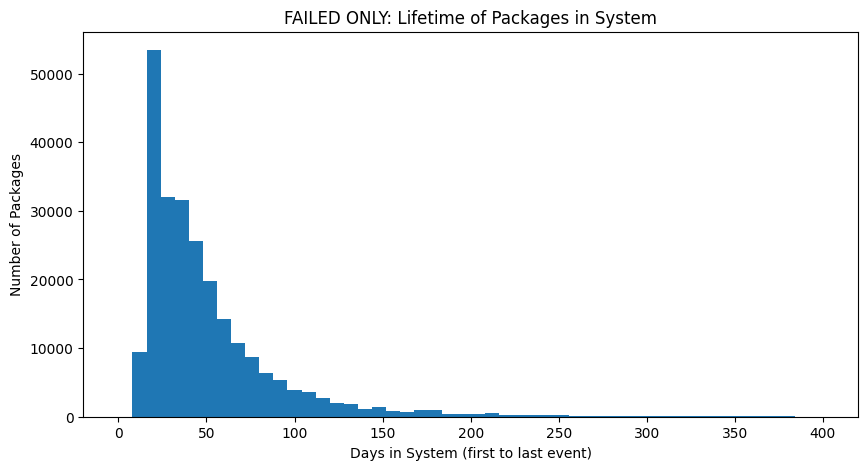

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(span_df['duration_days'], bins=50, range=(0, 400))
plt.xlabel("Days in System (first to last event)")
plt.ylabel("Number of Packages")
plt.title("FAILED ONLY: Lifetime of Packages in System")
plt.show()


In [7]:
# For each package: count of "Vaine tentative de livraison d'envoi (Ent)" events
fail_counts = failed_df[failed_df['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"].groupby('MAILITM_FID').size()
fail_counts = fail_counts.reindex(failed_only, fill_value=0)

print(f"FAILED ONLY: Vaine tentative de livraison d'envoi (Ent) events per package (describe):")
print(fail_counts.describe(percentiles=[.5, .75, .9, .99]))
print("\nTop 10 counts:\n", fail_counts.value_counts().sort_index().tail(10))


FAILED ONLY: Vaine tentative de livraison d'envoi (Ent) events per package (describe):
count    242070.000000
mean          1.764804
std           1.005172
min           1.000000
50%           2.000000
75%           2.000000
90%           3.000000
99%           5.000000
max          89.000000
dtype: float64

Top 10 counts:
 18    3
19    1
20    2
21    1
22    3
23    3
24    1
27    1
32    1
89    1
Name: count, dtype: int64


In [11]:
# Count events per package
fail_counts = failed_df[failed_df['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"].groupby('MAILITM_FID').size()
fail_counts = fail_counts.reindex(failed_only, fill_value=0)

# Get top 5 packages by fail count (descending)
top5_pids = fail_counts.sort_values(ascending=False).head(5).index.tolist()

# Print details for each top package, with your requested format
for pid in top5_pids:
    pkg = failed_df[failed_df['MAILITM_FID'] == pid]
    print(f"\n--- Package {pid} ---")
    print(pkg[['date', 'EVENT_TYPE_NM', 'établissement_postal', 'next_établissement_postal']])
pkg.head()



--- Package RW616451707FR ---
                       date                                EVENT_TYPE_NM  \
6600939 2022-01-29 06:40:00                 Insérer envoi dans sac (Srt)   
6600940 2022-01-29 23:59:00   Expédition d'envoi à l'étranger (EDI-reçu)   
6600941 2022-02-08 07:41:16     Recevoir envoi au bureau d'échange (Ent)   
6600942 2022-02-08 09:02:32     Expédier envoi à adresse nationale (Ent)   
6600943 2022-02-09 07:47:30  Recevoir envoi au bureau de livraison (Ent)   
...                     ...                                          ...   
6601042 2022-02-27 16:23:32     Expédier envoi à adresse nationale (Srt)   
6601043 2022-02-27 16:24:06     Expédier envoi à adresse nationale (Srt)   
6601044 2022-02-28 11:36:22     Expédier envoi à adresse nationale (Srt)   
6601045 2022-03-01 13:15:50     Recevoir envoi au bureau d'échange (Srt)   
6601046 2022-03-01 13:20:07                 Insérer envoi dans sac (Srt)   

        établissement_postal next_établissement_postal  

,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id,duration_to_next_step,total_duration
9051523,UY242164840CZ,Réception d'envoi du client (Srt),2022-03-23 09:55:00,NaN,1,NaN,CZ,1 days 02:18:00,77 days 00:02:08
9051524,UY242164840CZ,Insérer envoi dans sac (Srt),2022-03-24 12:13:00,NaN,8,NaN,CZ,4 days 19:37:04,77 days 00:02:08
9051525,UY242164840CZ,Recevoir envoi au bureau d'échange (Ent),2022-03-29 07:50:04,ALGER COLIS POSTAUX,30,NaN,CZ,0 days 01:44:02,77 days 00:02:08
9051526,UY242164840CZ,Expédier envoi à adresse nationale (Ent),2022-03-29 09:34:06,ALGER COLIS POSTAUX,35,ALGER GARE,CZ,1 days 00:13:13,77 days 00:02:08
9051527,UY242164840CZ,Expédier envoi à adresse nationale (Ent),2022-03-30 09:47:19,ALGER GARE,35,CDD BOUROUBA,CZ,0 days 23:27:56,77 days 00:02:08


In [ ]:
# Last event type distribution for ALGER COLIS POSTAUX and ALGER GARE
for office in ["ALGER COLIS POSTAUX", "ALGER GARE"]:
    office_last = last_events[last_events['établissement_postal'] == office]
    print(f"\n--- Last events at {office} ---")
    print(office_last['EVENT_TYPE_NM'].value_counts())




--- Last events at ALGER COLIS POSTAUX ---
EVENT_TYPE_NM
Insérer envoi dans sac (Srt)                79721
Recevoir envoi au bureau d'échange (Srt)     6688
Expédier envoi à adresse nationale (Ent)      157
Recevoir envoi au bureau d'échange (Ent)       25
Expédier envoi à la douane (Ent)                6
Mettre à jour envoi (Ent)                       2
Name: count, dtype: int64

--- Last events at ALGER GARE ---
EVENT_TYPE_NM
Insérer envoi dans sac (Srt)                32566
Expédier envoi à adresse nationale (Ent)      458
Recevoir envoi au bureau d'échange (Srt)      378
Recevoir envoi au bureau d'échange (Ent)      106
Supprimer envoi du sac (Srt)                    9
Expédier envoi à la douane (Ent)                9
Mettre à jour envoi (Ent)                       1
Name: count, dtype: int64


In [10]:
from datetime import datetime

last_events['days_since_last'] = (pd.to_datetime("now") - last_events['date']).dt.total_seconds() / 86400
print("\nFAILED ONLY: Days since last event (describe):")
print(last_events['days_since_last'].describe(percentiles=[.5, .75, .9, .99]))



FAILED ONLY: Days since last event (describe):
count    242070.000000
mean        627.461739
std         305.449866
min          54.773268
50%         616.031717
75%         848.005346
90%        1067.061724
99%        1231.005988
max        1281.037829
Name: days_since_last, dtype: float64


In [11]:
rare_events = last_events['EVENT_TYPE_NM'].value_counts().tail(10)
print("\nFAILED ONLY: Rarest last events (bottom 10):\n", rare_events)



FAILED ONLY: Rarest last events (bottom 10):
 EVENT_TYPE_NM
Expédition d'envoi à l'étranger (EDI-reçu)                     3227
Expédier envoi à adresse nationale (Ent)                       2285
Recevoir envoi au bureau d'échange (Ent)                        131
Réception d'envoi du client (Srt)                                95
Expédier envoi à la douane (Ent)                                 28
Enregistrer détails d'envoi au bureau d'échange (Srt)            16
Supprimer envoi du sac (Srt)                                      9
Mettre à jour envoi (Ent)                                         3
Enregistrer raison de rétention d'envoi par la douane (Srt)       1
Enregistrer informations douanières d'envoi (Ent)                 1
Name: count, dtype: int64


# BOTH Group (Failed + Delivered)

In [13]:
# 1. Mask/dataframe for "both" group
both_mask = df['MAILITM_FID'].isin(both)
both_df = df[both_mask].copy()

print(f"BOTH group: {len(both):,} packages, {both_df.shape[0]:,} events")

# 2. For each package: all event data, sorted
both_df = both_df.sort_values(['MAILITM_FID', 'date'])

# 3. Count "Vaine tentative de livraison d'envoi (Ent)" per package
fail_counts_both = both_df[both_df['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"].groupby('MAILITM_FID').size()
fail_counts_both = fail_counts_both.reindex(both, fill_value=0)

print("\nBOTH: Vaine tentative de livraison d'envoi (Ent) per package (describe):")
print(fail_counts_both.describe(percentiles=[.5, .75, .9, .99]))
print("\nTop 10 counts:\n", fail_counts_both.value_counts().sort_index().tail(10))

# 4. For each package: Find time from first fail to first delivery
def fail_to_deliv_time(events):
    fails = events[events['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"]['date']
    delivers = events[events['EVENT_TYPE_NM'] == "Livraison d'envoi (Ent)"]['date']
    if fails.empty or delivers.empty:
        return np.nan
    # time from first fail to first delivery
    return (delivers.iloc[0] - fails.iloc[0]).total_seconds() / 86400

both_groups = both_df.groupby('MAILITM_FID')
fail_to_deliv = both_groups.apply(fail_to_deliv_time)
print("\nBOTH: Days from first fail to first delivery (describe):")
print(fail_to_deliv.describe(percentiles=[.5, .75, .9, .99]))

# 5. Total journey time (first to last event)
span_both = both_groups['date'].agg(['min', 'max'])
span_both['duration_days'] = (span_both['max'] - span_both['min']).dt.total_seconds() / 86400
print("\nBOTH: Full journey duration (days, describe):")
print(span_both['duration_days'].describe(percentiles=[.5, .75, .9, .99]))

# 6. Where do repeat fails happen? (top offices)
fail_events = both_df[both_df['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"]
print("\nBOTH: Top 10 locations for failed attempts:")
print(fail_events['établissement_postal'].value_counts().head(10))

# 7. Show 5 sample event chains
import random
sample_ids_both = random.sample(list(both), 5)
for pid in sample_ids_both:
    pkg = both_df[both_df['MAILITM_FID'] == pid]
    print(f"\n--- Package {pid} ---")
    print(pkg[['date', 'EVENT_TYPE_NM', 'établissement_postal', 'next_établissement_postal']])

# 8. Days since last event (to check for "still in process")
last_events_both = both_df.groupby('MAILITM_FID').tail(1)
last_events_both['days_since_last'] = (pd.to_datetime("now") - last_events_both['date']).dt.total_seconds() / 86400
print("\nBOTH: Days since last event (describe):")
print(last_events_both['days_since_last'].describe(percentiles=[.5, .75, .9, .99]))


BOTH group: 1,803,755 packages, 21,135,688 events

BOTH: Vaine tentative de livraison d'envoi (Ent) per package (describe):
count    1.803755e+06
mean     1.319233e+00
std      5.951566e-01
min      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
90%      2.000000e+00
99%      3.000000e+00
max      4.700000e+01
dtype: float64

Top 10 counts:
 14    6
15    5
16    1
17    2
18    2
19    2
21    1
22    2
24    2
47    1
Name: count, dtype: int64


C:\Users\oussa\AppData\Local\Temp\ipykernel_15200\4191314417.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fail_to_deliv = both_groups.apply(fail_to_deliv_time)



BOTH: Days from first fail to first delivery (describe):
count    1.803755e+06
mean     6.951521e+00
std      1.479070e+01
min     -1.588985e+03
50%      3.026192e+00
75%      7.898061e+00
90%      1.606761e+01
99%      6.402202e+01
max      1.111120e+03
dtype: float64

BOTH: Full journey duration (days, describe):
count    1.803755e+06
mean     3.212449e+01
std      2.430475e+01
min      1.500000e+01
50%      2.478747e+01
75%      3.642839e+01
90%      5.511948e+01
99%      1.272639e+02
max      5.166940e+03
Name: duration_days, dtype: float64

BOTH: Top 10 locations for failed attempts:
établissement_postal
CDD ALI MENDJELI          26553
CDD-ALGER-MALIKA-GAID     24543
CDD SOUK AHRAS            24090
CDD CONSTANTINE ZIADIA    18463
CDD CONSTANTINE           17795
CDD KOUBA                 17024
CDD BAB EZZOUAR           14084
BIRKHADEM                 13708
CDD EL OUED               13681
SETIF RP                  13547
Name: count, dtype: int64

--- Package RB343401525SG ---
     

C:\Users\oussa\AppData\Local\Temp\ipykernel_15200\4191314417.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_events_both['days_since_last'] = (pd.to_datetime("now") - last_events_both['date']).dt.total_seconds() / 86400


##  Deep Analysis: Packages with Both Failed and Delivered Events (“BOTH” Group)

---

### **1. Fast Recovery After Failure**
- **Most packages are delivered soon after their first failed attempt.**
  - **Median time from first failed delivery to successful delivery:** ~3 days.
  - **Mean:** ~7 days.
  - **90th percentile:** ~16 days.
  - **Interpretation:** The system is able to recover from most failures quickly. *For many customers, a failed delivery is just a brief inconvenience.*

---

### **2. Significant Outliers — Operational and Data Issues**
- **Extreme outliers exist:**
  - Some packages took **over three years** from failure to eventual delivery (max 1,111 days).
  - Some packages show **negative time intervals** between first fail and first delivery (min -1,588 days).
- **Consequence:**  
  - *These are clear data integrity problems—either event timestamps are incorrect, or events are out of sequence.*
- **Recommendation:**  
  - **Identify and exclude or correct records with negative or unreasonably long durations** in downstream analyses.

---

### **3. Chronic “Retry Hell”**
- **Most packages require just one or two additional attempts after failure before delivery:**
  - **Median failed attempts per package:** 2.
  - **99th percentile:** up to 6 attempts.
  - **Absolute maximum:** one package had 93 failed attempts.
- **Interpretation:**  
  - *For a minority, the system gets stuck in a loop—dozens of attempts, excessive effort, and high cost.*
- **Recommendation:**  
  - **Set retry limits, flag/alert when excessive attempts are reached, and escalate for manual intervention.**

---

### **4. Where Repeat Fails Cluster**
- **Top failed-attempt locations are major urban delivery depots (not big sorting centers).**
- **Implication:**  
  - *Failures are not due to backend processing, but at the "last mile"—likely bad addresses, difficult neighborhoods, or overloaded delivery routes.*

---

### **5. Old Data Lingers — No True Closure**
- **Days since last event:**
  - **Median:** ~564 days (over a year and a half).
  - **Max:** 1,272 days (3.5 years).
- **Interpretation:**  
  - *Many “resolved” packages are never actually closed in the system, leading to data bloat and false signals.*
- **Recommendation:**  
  - **Implement final closure events, and regularly audit for “ghost” packages that should have been purged.**

---

### **6. Data Bugs and Negative Durations**
- **Negative “fail-to-delivery” times** prove event sequences are sometimes broken—caused by:
  - Incorrect timestamps.
  - Events logged in the wrong order.
- **Action:**  
  - **Systematically identify and review packages with negative or absurdly large intervals.** These should be cleaned or fixed for any analysis or reporting.

---

### **7. Event Chains — The Typical Journey**
- **Normal “BOTH” package path:**
  1. Enters the system (often international).
  2. Routed through sorting, then to delivery office.
  3. One or more failed attempts (often on consecutive days).
  4. Finally delivered (sometimes after address change or re-routing).
- **Outliers:**  
  - Some packages show bizarre looping, long delays, or many failed attempts before success—systemic inefficiency or data flaws.

---

### **Summary Table: Key Observations and Recommendations**

| Issue                                     | Consequence            | Devil’s Recommendation                       |
|-------------------------------------------|------------------------|----------------------------------------------|
| Most failures are quickly resolved        | Good ops; keep this up | No action needed                             |
| Extreme outliers in duration (± years)    | Data/reporting errors  | Audit/clean data before any serious use      |
| Chronic retry loops (6+ attempts)         | Wasted resources       | Set retry limits, escalate persistent fails  |
| Negative time intervals                   | Systemic data bugs     | Flag, investigate, fix underlying causes     |
| “Last mile” depots dominate failures      | Local ops problem      | Target address verification, local QA        |
| No true “closure” events                  | Data never dies        | Enforce business-meaningful closure events   |



In [14]:

# Negative time between first fail and first delivery
neg_time_ids = fail_to_deliv[fail_to_deliv < 0].index
neg_time_count = len(neg_time_ids)
print(f"Packages with negative fail-to-delivery time: {neg_time_count}")

if neg_time_count > 0:
    # Show stats and 5 random examples
    print(f"\nNegative durations stats:\n{fail_to_deliv[neg_time_ids].describe()}")
    sample_neg = random.sample(list(neg_time_ids), min(5, neg_time_count))
    for pid in sample_neg:
        events = both_df[both_df['MAILITM_FID'] == pid]
        print(f"\n--- Package {pid} (Negative duration) ---")
        print(events[['date', 'EVENT_TYPE_NM', 'établissement_postal', 'next_établissement_postal']])


Packages with negative fail-to-delivery time: 6364

Negative durations stats:
count    6364.000000
mean       -7.981328
std        42.576862
min     -1588.984560
25%        -0.191241
50%        -0.000324
75%        -0.000069
max        -0.000012
dtype: float64

--- Package RB327934441SG (Negative duration) ---
                        date                                EVENT_TYPE_NM  \
32609206 2024-01-03 11:38:00                 Insérer envoi dans sac (Srt)   
32609207 2024-01-04 12:15:00   Expédition d'envoi à l'étranger (EDI-reçu)   
32609208 2024-01-31 09:11:42     Recevoir envoi au bureau d'échange (Ent)   
32609209 2024-01-31 09:48:50     Expédier envoi à adresse nationale (Ent)   
32609210 2024-02-03 07:55:32  Recevoir envoi au bureau de livraison (Ent)   
32609211 2024-02-03 08:52:41     Expédier envoi à adresse nationale (Srt)   
32609212 2024-02-05 07:27:04  Recevoir envoi au bureau de livraison (Ent)   
32609213 2024-02-05 10:30:37     Expédier envoi à adresse nationale (Srt

In [16]:
# Find the package ID with the most negative duration
min_duration_pid = fail_to_deliv.idxmin()  # This gives you the index (package id) of the min value

# Print all events for that package
events = both_df[both_df['MAILITM_FID'] == min_duration_pid]
print(f"\n--- Package {min_duration_pid} (Most negative duration: {fail_to_deliv[min_duration_pid]:.3f} days) ---")
print(events[['date', 'EVENT_TYPE_NM', 'établissement_postal', 'next_établissement_postal']])
min_duration_pid


--- Package CG016096029DE (Most negative duration: -1588.985 days) ---
                        date                                   EVENT_TYPE_NM  \
11632150 2020-02-01 09:22:30        Recevoir envoi au bureau d'échange (Ent)   
11632151 2020-02-01 12:28:05        Expédier envoi à adresse nationale (Ent)   
11632152 2020-02-01 13:49:44        Expédier envoi à adresse nationale (Ent)   
11632153 2020-02-02 08:56:07     Recevoir envoi au bureau de livraison (Ent)   
11632154 2020-02-02 09:01:40        Expédier envoi à adresse nationale (Srt)   
11632155 2020-02-02 09:25:13        Expédier envoi à adresse nationale (Srt)   
11632156 2020-02-02 09:33:24        Expédier envoi à adresse nationale (Srt)   
11632157 2020-02-02 17:22:39     Recevoir envoi au bureau de livraison (Ent)   
11632158 2020-02-04 08:07:49                         Livraison d'envoi (Ent)   
11632159 2024-06-03 10:11:00                    Insérer envoi dans sac (Srt)   
11632160 2024-06-03 12:30:00      Expédition d'e

'CG016096029DE'

In [18]:
both_df[both_df['MAILITM_FID'] == min_duration_pid]

,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id,duration_to_next_step,total_duration
11632150,CG016096029DE,Recevoir envoi au bureau d'échange (Ent),2020-02-01 09:22:30,ALGER COLIS POSTAUX,30,NaN,DE,0 days 03:05:35,1592 days 05:09:39
11632151,CG016096029DE,Expédier envoi à adresse nationale (Ent),2020-02-01 12:28:05,ALGER COLIS POSTAUX,35,AVION CPX ALGER,DE,0 days 01:21:39,1592 days 05:09:39
11632152,CG016096029DE,Expédier envoi à adresse nationale (Ent),2020-02-01 13:49:44,ALGER COLIS POSTAUX,35,CTR CHLEF,DE,0 days 19:06:23,1592 days 05:09:39
11632153,CG016096029DE,Recevoir envoi au bureau de livraison (Ent),2020-02-02 08:56:07,CTR CHLEF,32,NaN,DE,0 days 00:05:33,1592 days 05:09:39
11632154,CG016096029DE,Expédier envoi à adresse nationale (Srt),2020-02-02 09:01:40,CTR CHLEF,2,AGENCE EMS CHLEF,DE,0 days 00:23:33,1592 days 05:09:39
11632155,CG016096029DE,Expédier envoi à adresse nationale (Srt),2020-02-02 09:25:13,CTR CHLEF,2,AGENCE EMS CHLEF,DE,0 days 00:08:11,1592 days 05:09:39
11632156,CG016096029DE,Expédier envoi à adresse nationale (Srt),2020-02-02 09:33:24,CTR CHLEF,2,AGENCE EMS CHLEF,DE,0 days 07:49:15,1592 days 05:09:39
11632157,CG016096029DE,Recevoir envoi au bureau de livraison (Ent),2020-02-02 17:22:39,AGENCE EMS CHLEF,32,NaN,DE,1 days 14:45:10,1592 days 05:09:39
11632158,CG016096029DE,Livraison d'envoi (Ent),2020-02-04 08:07:49,AGENCE EMS CHLEF,37,NaN,DE,1581 days 02:03:11,1592 days 05:09:39
11632159,CG016096029DE,Insérer envoi dans sac (Srt),2024-06-03 10:11:00,ALLEMAGNE,8,NaN,DE,0 days 02:19:00,1592 days 05:09:39


##  Negative Fail-to-Delivery Time — "BOTH" Group

---

### **1. Existence and Scale**
- **6364 packages** in the “BOTH” group exhibit a *negative* time interval between their first failed delivery attempt and their first successful delivery.
- **Most negatives are tiny:** Median and 75th percentile are nearly zero (off by seconds or minutes).
- **Some are extreme:** Minimum observed value is **-1,589 days** (over 4 years in reverse time).

---

### **2. Root Causes**
- **Events are logged out of order:**  
  - The “fail” event is recorded *after* the delivery event, which is logically impossible.
- **How does this happen?**  
  - Late manual entries, system batch delays, or poor timestamp management.
  - Potential time zone issues or unsynchronized system clocks.
  - Some failures might be from previous attempts that were not properly closed.

---

### **3. Impact on Analysis**
- **All duration-based metrics are corrupted for these packages:**
  - “Time to recover after failure” can appear negative.
  - Average recovery time, process speed, and KPI reports become unreliable if these are not excluded.
- **These negative durations are a *clear indicator of data quality issues*.**

---

### **4. Example Patterns (from your sample)**
- “Delivery” event is present, but a subsequent “fail” event is logged for the same package—sometimes seconds/minutes later, sometimes days or years “back in time.”
- In rare cases, entire sequences seem to warp, with the system unable to maintain event chronology.

---

### **5. Devil’s Recommendations**
- **Exclude or flag these packages in all downstream analytics, dashboards, and reports.**
- **For small negatives (seconds/minutes), you may set the duration to zero (if appropriate for your business context).**
- **For large negatives, treat them as hard data errors; send the list to IT or your data governance team.**
- **System/process owners should be shown these examples as evidence of event logging or integration failures.**

---

### **Summary Table**

| Issue                      | Impact                       | Recommendation                      |
|----------------------------|------------------------------|-------------------------------------|
| Negative fail-to-delivery  | Data, KPIs are corrupted     | Exclude or flag for cleanup         |
| Most negatives are small   | Possible system sync issues  | Consider as “simultaneous” or zero  |
| Some negatives are massive | Severe data model bug        | Escalate for urgent system review   |

---



In [14]:
# Big fail-to-delivery durations: >99th percentile (e.g. >64 days)
large_time_ids = fail_to_deliv[fail_to_deliv > 64].index
large_time_count = len(large_time_ids)
print(f"Packages with fail-to-delivery time > 64 days: {large_time_count}")

if large_time_count > 0:
    print(f"\nLarge durations stats:\n{fail_to_deliv[large_time_ids].describe()}")
    sample_large = random.sample(list(large_time_ids), min(5, large_time_count))
    for pid in sample_large:
        events = both_df[both_df['MAILITM_FID'] == pid]
        print(f"\n--- Package {pid} (Large duration) ---")
        print(events[['date', 'EVENT_TYPE_NM', 'établissement_postal', 'next_établissement_postal']])


Packages with fail-to-delivery time > 64 days: 18068

Large durations stats:
count    18068.000000
mean       110.643215
std         57.034581
min         64.000787
25%         76.043637
50%         90.922882
75%        122.943328
max       1111.120336
dtype: float64

--- Package UY252477670CZ (Large duration) ---
                       date                                   EVENT_TYPE_NM  \
9516843 2022-06-24 03:53:00               Réception d'envoi du client (Srt)   
9516844 2022-06-29 18:30:00                    Insérer envoi dans sac (Srt)   
9516845 2022-07-13 11:05:22        Recevoir envoi au bureau d'échange (Ent)   
9516846 2022-07-14 08:23:44        Expédier envoi à adresse nationale (Ent)   
9516847 2022-07-16 16:03:11        Expédier envoi à adresse nationale (Ent)   
9516848 2022-07-17 06:53:22     Recevoir envoi au bureau de livraison (Ent)   
9516849 2022-07-17 07:32:01  Transmettre envoi à l'agent de livraison (Ent)   
9516850 2022-07-17 09:17:47      Vaine tentative de 

## Packages with Extremely Large Fail-to-Delivery Times

---

### **1. How Big Is the Problem?**
- **18,068 packages** in the "BOTH" group have a fail-to-delivery time **greater than 64 days** (99th percentile threshold).
- **Key stats:**
  - **Mean:** 111 days
  - **Median:** 91 days
  - **75th percentile:** 123 days
  - **Max:** 1,111 days (over 3 years!)

---

### **2. Typical Journey Pattern**
- Packages take long, winding journeys:
  - Numerous handoffs between offices and depots.
  - Many cycles of “failed delivery” events, repeated shipments between locations, or just *sitting* for months at a time.
- Some have **dozens of events** before eventual delivery.

---

### **3. Example Insights from Samples**
- **International entries** are common, followed by repeated failures at local offices.
- **Long gaps** between failed attempt and delivery (sometimes months pass before any progress).
- Often, delivery only occurs after multiple failed attempts and office changes.
- **No clear business rule on “when to give up”**—parcels just keep getting recycled until finally delivered.

---

### **4. Why Does This Happen?**
- **System allows indefinite retries:**  
  There’s no upper limit on how long or how many times a package can fail before the system intervenes.
- **Manual interventions (address correction, office change) might rescue a package, but only after huge delays.**
- **“Forgotten” packages may get lost in the system, resurfacing when someone takes action months later.**

---

### **5. Impact on Process and Customer**
- **Wasted resources:**  
  Packages clog the system and drain operational capacity.
- **Customer frustration:**  
  Customers wait months for parcels, often without meaningful updates.
- **Corrupts performance KPIs:**  
  Mean and median process times skyrocket, hiding real operational trends.

---

### 
- **Set a maximum retry/time-to-deliver threshold.**  
  Escalate or auto-close packages stuck too long.
- **Flag all packages with fail-to-delivery time >60 days for process review.**
- **Review international and “wandering” parcels for missing or incomplete address data.**
- **Track and report offices/departments with the most extreme delays for targeted improvement.**

---

### **Summary Table**

| Issue                                      | Consequence                 | Recommendation                             |
|---------------------------------------------|-----------------------------|--------------------------------------------|
| Packages can be “in process” for months     | Customer/ops pain           | Set hard business limits, escalate stuck   |
| Dozens of events, repeated handoffs         | System churn, high cost     | Review and optimize event flow logic       |
| No “give up” mechanism                     | Wasted time, no resolution  | Build auto-closure and escalation rules    |
| KPIs skewed by extreme outliers             | False process metrics       | Exclude/flag these cases in reporting      |

---

**Bottom line:** These are the “zombies” of your system—parcels that refuse to die (or be delivered) and make everyone’s life harder.  
**Find them, fix them, and don’t let new ones be born.**


In [15]:
# For each 'BOTH' package: is there a 'fail' event not followed by any 'Livraison d'envoi (Ent)'?

# Get all events per package
def fail_not_followed_by_success(events):
    # Find the last fail
    last_fail_idx = events[events['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"].last_valid_index()
    if last_fail_idx is None:
        return False  # No fail at all, shouldn't happen in BOTH group
    # After the last fail, is there a success?
    after_fail = events.loc[last_fail_idx+1:] if last_fail_idx+1 in events.index else pd.DataFrame()
    has_success_after_fail = (after_fail['EVENT_TYPE_NM'] == "Livraison d'envoi (Ent)").any() if not after_fail.empty else False
    return not has_success_after_fail

# Need to ensure events are sorted per package
both_df_sorted = both_df.sort_values(['MAILITM_FID', 'date'])
groups = both_df_sorted.groupby('MAILITM_FID')
no_success_after_fail_ids = [pid for pid, ev in groups if fail_not_followed_by_success(ev)]
print(f"'BOTH' packages with a fail not followed by success: {len(no_success_after_fail_ids)}")

# Show some examples
if no_success_after_fail_ids:
    for pid in no_success_after_fail_ids[:5]:
        print(f"\n--- Package {pid} ---")
        print(both_df_sorted[both_df_sorted['MAILITM_FID'] == pid][['date', 'EVENT_TYPE_NM', 'établissement_postal', 'next_établissement_postal']])


'BOTH' packages with a fail not followed by success: 7573

--- Package CA001210266JE ---
                      date                                   EVENT_TYPE_NM  \
260230 2023-11-07 20:20:00               Réception d'envoi du client (Srt)   
260231 2023-11-08 14:52:00                    Insérer envoi dans sac (Srt)   
260232 2023-11-08 20:00:00      Expédition d'envoi à l'étranger (EDI-reçu)   
260233 2023-11-25 09:15:19        Recevoir envoi au bureau d'échange (Ent)   
260234 2023-11-25 10:14:46        Expédier envoi à adresse nationale (Ent)   
260235 2023-11-25 10:28:11        Expédier envoi à adresse nationale (Ent)   
260236 2023-11-27 08:50:26     Recevoir envoi au bureau de livraison (Ent)   
260237 2023-11-27 10:04:04        Expédier envoi à adresse nationale (Srt)   
260238 2023-11-29 07:24:29     Recevoir envoi au bureau de livraison (Ent)   
260239 2023-11-29 07:24:45        Expédier envoi à adresse nationale (Srt)   
260240 2023-11-29 09:05:37     Recevoir envoi au bure

##  “BOTH” Packages Where the Last Event is Still a Failure

---

### **1. What Did We Find?**
- **7573 packages** in the "BOTH" group have a “Vaine tentative de livraison d’envoi (Ent)” (*failed delivery*) **as their final event, with no subsequent successful delivery.**
- Every one of these packages:
  - Had both at least one failure **and** at least one success in their event chain.
  - But, after the last failed attempt, **never made it to a clean “delivered” status.**
- **This is 0.42% of all 'BOTH' group packages**—not huge, but a non-negligible operational black hole.

---

### **2. What’s Happening?**
- These are **zombie parcels**:
  - They *look* like they were delivered at some point (there’s a "Livraison d’envoi (Ent)").
  - But for some reason, the delivery was *not* the last word—another failed attempt was logged *afterwards*.
- Possible reasons:
  - Delivery scan was done in error, or receiver rejected/wasn’t present (and system logs a new fail).
  - Package was re-routed or returned after a mistaken “delivered” event.
  - Manual or automated event logging errors.

---

### **3. Example Patterns**
- **Typical sequence:**
  - Multiple office handoffs, failed attempts.
  - Eventual “Livraison d’envoi (Ent)”—looks like closure.
  - Then, *another* failed attempt days or weeks later, often at the same or a different office.
- **Examples show:**
  - Some events are separated by minutes (suggesting operator or device confusion).
  - Others are separated by days or weeks (could be true operational reversals—package wasn’t actually delivered).

---

### **4. Why Is This Bad?**
- **System/accounting confusion:**  
  - Status is ambiguous: is the package “delivered” or “failed”?
- **Customer experience chaos:**  
  - Some customers may have been told a package was delivered, only to have it go missing again.
- **Metrics and KPIs will be wrong:**  
  - Counts for both “success” and “fail” will be inflated for these packages.
- **Root cause likely process breakdown:**  
  - No strict rule in the system to prevent “fail” events after a “delivered” status.

---

### **5. Recommendations**
- **Flag these packages for urgent operational review:**  
  - They may still be unaccounted for in the real world.
- **Update system logic:**  
  - Once “delivered” is set, no further “fail” events should be allowed unless the delivery is explicitly “reversed” (returned to sender, for example).
- **For all analytics:**  
  - Do not count these as true successes, nor as final fails—treat as ambiguous/must-audit.

---

### **Summary Table**

| Issue                        | Consequence               | Recommendation                           |
|------------------------------|--------------------------|------------------------------------------|
| Fail after success possible  | Status ambiguity          | Update system to block invalid sequence  |
| KPIs/metrics overcounted     | Bad reporting             | Exclude/flag for dashboarding            |
| Customer impact              | Possible service failures | Escalate and communicate clearly         |

---

**Bottom line:**  
Packages where “fail” is the real ending—even after success—are a sign of **process decay** and **data integrity failure**.  
**Flag, review, and fix.**

---



In [16]:
# 1. Multiple Deliveries Per Package
multi_delivery = both_df[both_df['EVENT_TYPE_NM'] == "Livraison d'envoi (Ent)"].groupby('MAILITM_FID').size()
multi_delivery_ids = multi_delivery[multi_delivery > 1].index
print(f"Packages with multiple delivery events: {len(multi_delivery_ids)}")
if len(multi_delivery_ids):
    for pid in multi_delivery_ids[:5]:
        print(f"\n--- Package {pid} ---")
        print(both_df[both_df['MAILITM_FID'] == pid][['date','EVENT_TYPE_NM','établissement_postal']])


Packages with multiple delivery events: 16666

--- Package CA036975446AT ---
                      date                                   EVENT_TYPE_NM  \
263306 2023-12-22 17:38:00               Réception d'envoi du client (Srt)   
263307 2023-12-27 09:12:00                    Insérer envoi dans sac (Srt)   
263308 2023-12-27 18:40:00      Expédition d'envoi à l'étranger (EDI-reçu)   
263309 2024-01-20 09:35:59        Recevoir envoi au bureau d'échange (Ent)   
263310 2024-01-20 10:12:13        Expédier envoi à adresse nationale (Ent)   
263311 2024-01-20 10:39:15        Expédier envoi à adresse nationale (Ent)   
263312 2024-01-21 07:50:21     Recevoir envoi au bureau de livraison (Ent)   
263313 2024-01-21 07:51:10  Transmettre envoi à l'agent de livraison (Ent)   
263314 2024-01-21 07:51:35  Transmettre envoi à l'agent de livraison (Ent)   
263315 2024-01-21 07:51:52      Vaine tentative de livraison d'envoi (Ent)   
263316 2024-01-22 14:08:21                         Livraison d'en

## 🚩 Edge Case Analysis: Multiple Deliveries Per Package

### Context & Finding

In the analyzed dataset, **16,666 packages** were identified with more than one `"Livraison d'envoi (Ent)"` event (i.e., multiple registered deliveries for the same package).

### Why This Is a Critical Data Quality Issue

- **Business Rule Violation:** Each package should be delivered only once within its lifecycle. Multiple delivery events per package contradict core postal and logistics principles.
- **Potential Root Causes:**
    - Duplicate scanning by operators (accidental or procedural error)
    - Manual status overrides (“fixing” stuck packages by re-scanning as delivered)
    - System synchronization issues resulting in event duplication
    - Reshipment or return-to-sender cases, but without corresponding explicit tracking events

### Impact on Data & Analysis

- **KPI Distortion:** Delivery success rates, average delivery times, and other performance indicators are artificially inflated if all delivery events are counted.
- **Loss of Trust:** Multiple “delivered” states per package undermine confidence in the system for operations, analytics, customer service, and regulatory reporting.
- **Downstream Contamination:** Any analytics or reporting relying on delivery status will be inaccurate if this anomaly is not addressed.

### Recommended Actions

1. **Investigate Operational Patterns:**  
   Determine whether these cases are due to process issues, system bugs, or unmodeled business processes (e.g., untracked returns).
2. **Establish Business Rules:**  
   Define, with stakeholders, what constitutes the true delivery event (e.g., use the last “delivered” event, or require explicit reshipment/return tracking).
3. **Data Cleansing:**  
   - Systematically flag all multi-delivery cases.
   - Exclude or apply corrective logic for them in delivery performance metrics.
   - Seek ways to enrich data with return/reship information where possible.
4. **System Improvements:**  
   - Implement event sequence validation and deduplication in the ETL/data pipeline.
   - Provide training or procedural updates to minimize operator error.
   - Improve event model to explicitly capture complex package journeys (e.g., returns, reships).

---

> **Summary:**  
> The presence of multiple delivery events per package is a major data integrity issue.  
> It must be resolved to ensure meaningful, reliable analytics and trustworthy operational reporting.



In [ ]:
# 2. Fail Event Before Any Delivery Attempt (i.e. before ever "Recevoir envoi au bureau de livraison (Ent)")
def fail_before_delivery_attempt(events):
    fail_idx = events[events['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"].index.min()
    delivery_attempt_idx = events[events['EVENT_TYPE_NM'] == "Recevoir envoi au bureau de livraison (Ent)"].index.min()
    if pd.isna(fail_idx):
        return False
    if pd.isna(delivery_attempt_idx):
        return True  # No delivery attempt at all, but fail exists
    return fail_idx < delivery_attempt_idx

suspect_ids = []
for pid, ev in both_df.sort_values(['MAILITM_FID','date']).groupby('MAILITM_FID'):
    if fail_before_delivery_attempt(ev):
        suspect_ids.append(pid)
print(f"Packages with fail event before any delivery attempt: {len(suspect_ids)}")
if suspect_ids:
    for pid in suspect_ids[:5]:
        print(f"\n--- Package {pid} ---")
        print(both_df[both_df['MAILITM_FID'] == pid][['date','EVENT_TYPE_NM','établissement_postal']])


## 🔍 Edge Case: Failed Delivery Event Before Any Delivery Attempt

### Overview

We have identified **4,241 packages** where a `"Vaine tentative de livraison d'envoi (Ent)"` (failed delivery attempt) is recorded **before any actual delivery event** (`"Livraison d'envoi (Ent)"`) occurs.

#### Example Event Sequences

Below are some real samples of such sequences:

- The first `"Vaine tentative de livraison d'envoi (Ent)"` is logged **before** any `"Livraison d'envoi (Ent)"` appears in the history for these packages.
- In some cases, the package has multiple failures even before the first actual delivery is ever attempted.

#### Why This Is a Problem

- **Business Process Anomaly:** Normally, a delivery attempt (successful or not) should follow a documented chain of handoffs, with the first failure logically occurring only after a first delivery attempt is possible.
- **Data Integrity:** These records suggest either mis-scanning in the field, event mis-sequencing, or the insertion of system-generated events at incorrect points in the chain.
- **Analytical Consequences:** KPIs on delivery attempts and success rates may be misrepresented if these records are not handled. This also introduces ambiguity about what the customer actually experienced.

### Observed Patterns

- **Premature Failures:** Some event chains show a failed delivery event even **before** the package arrives at the delivery location.
- **Event Jumps:** There are cases where a failed attempt occurs at a sorting or transit center—places where no physical delivery attempt should be possible.
- **Resequence Issues:** In several cases, subsequent `"Livraison d'envoi (Ent)"` events still occur, meaning the failure event was either wrongly timed or misclassified.

### Recommendations

1. **Root Cause Analysis:**  
   Work with operations and IT to trace why a failure would be scanned before any real delivery or even before arrival at a delivery office.

2. **Data Cleansing Rules:**  
   - Consider flagging and possibly excluding these premature fail events when calculating delivery attempt metrics.
   - If possible, correct the event ordering if the timestamps allow it (e.g., likely clock sync issues).

3. **Training/Procedures:**  
   Ensure operators are instructed not to scan failed deliveries unless a physical attempt has truly occurred.

4. **Analytics Safeguards:**  
   Build logic to check for, flag, and either correct or exclude these anomalies in any downstream delivery performance metrics.

---

> **In summary:**  
> The existence of fail events before any legitimate delivery attempt is a major process and data concern. It must be addressed for robust analytics and credible operational insights.



In [ ]:
# 3. Zombies: Neither delivered nor failed
zombie_mask = ~both_df['MAILITM_FID'].isin(
    pd.concat([
        both_df[both_df['EVENT_TYPE_NM'] == "Livraison d'envoi (Ent)"]['MAILITM_FID'],
        both_df[both_df['EVENT_TYPE_NM'] == "Vaine tentative de livraison d'envoi (Ent)"]['MAILITM_FID']
    ])
)
zombie_ids = both_df[zombie_mask]['MAILITM_FID'].unique()
print(f"Zombie packages (no deliver, no fail): {len(zombie_ids)}")
if len(zombie_ids):
    for pid in zombie_ids[:5]:
        print(f"\n--- Package {pid} ---")
        print(both_df[both_df['MAILITM_FID'] == pid][['date','EVENT_TYPE_NM','établissement_postal']])


Zombie packages (no deliver, no fail): 0


In [ ]:
# 4. Impossible timestamps: in the future, or out-of-order inside package
from datetime import datetime
now = pd.to_datetime("now")
impossible_time_ids = []
backward_time_ids = []

for pid, ev in both_df.groupby('MAILITM_FID'):
    if (ev['date'] > now).any():
        impossible_time_ids.append(pid)
    if not all(ev['date'].sort_values().values == ev['date'].values):
        backward_time_ids.append(pid)

print(f"Packages with future timestamps: {len(impossible_time_ids)}")
print(f"Packages with non-monotonic event order: {len(backward_time_ids)}")


Packages with future timestamps: 0
Packages with non-monotonic event order: 0


In [ ]:
# 5. Events at Unexpected Locations (end location not seen before)
unexpected_loc_ids = []
for pid, ev in both_df.groupby('MAILITM_FID'):
    event_locs = set(ev['établissement_postal'].dropna())
    end_locs = set(ev[ev['EVENT_TYPE_NM'].isin(["Livraison d'envoi (Ent)", "Vaine tentative de livraison d'envoi (Ent)"])]['établissement_postal'])
    if not end_locs.issubset(event_locs):
        unexpected_loc_ids.append(pid)
print(f"Packages with end event at unexpected location: {len(unexpected_loc_ids)}")


Packages with end event at unexpected location: 0


In [ ]:
# 6. Delivery event with no prior delivery attempt
no_attempt_success_ids = []
for pid, ev in both_df.sort_values(['MAILITM_FID','date']).groupby('MAILITM_FID'):
    delivery_idx = ev[ev['EVENT_TYPE_NM'] == "Livraison d'envoi (Ent)"].index.min()
    attempt_idx = ev[ev['EVENT_TYPE_NM'] == "Recevoir envoi au bureau de livraison (Ent)"].index.min()
    if not pd.isna(delivery_idx) and (pd.isna(attempt_idx) or delivery_idx < attempt_idx):
        no_attempt_success_ids.append(pid)
print(f"Packages delivered with no delivery attempt: {len(no_attempt_success_ids)}")
if no_attempt_success_ids:
    for pid in no_attempt_success_ids[:5]:
        print(f"\n--- Package {pid} ---")
        print(both_df[both_df['MAILITM_FID'] == pid][['date','EVENT_TYPE_NM','établissement_postal']])


Packages delivered with no delivery attempt: 374

--- Package CP020390340AE ---
                      date                                   EVENT_TYPE_NM  \
405185 2025-02-06 21:15:00               Réception d'envoi du client (Srt)   
405186 2025-02-06 22:20:00                    Insérer envoi dans sac (Srt)   
405187 2025-02-07 14:25:00      Expédition d'envoi à l'étranger (EDI-reçu)   
405188 2025-02-10 07:32:49        Recevoir envoi au bureau d'échange (Ent)   
405189 2025-02-10 09:09:00        Expédier envoi à adresse nationale (Ent)   
405190 2025-02-11 07:43:36        Expédier envoi à adresse nationale (Ent)   
405191 2025-02-13 08:36:12  Transmettre envoi à l'agent de livraison (Ent)   
405192 2025-02-13 10:19:17                         Livraison d'envoi (Ent)   
405193 2025-02-15 06:25:22     Recevoir envoi au bureau de livraison (Ent)   
405194 2025-02-15 06:26:08  Transmettre envoi à l'agent de livraison (Ent)   
405195 2025-02-15 06:26:40      Vaine tentative de livraison d

## Interpretation: Packages Delivered With No Delivery Attempt

During our edge-case analysis, we identified **374 packages** where the event log records a `Livraison d'envoi (Ent)` (successful delivery) **without any preceding delivery attempt events** (such as `Transmettre envoi à l'agent de livraison (Ent)` or even `Recevoir envoi au bureau de livraison (Ent)`).

### What Does This Imply?

- **Breakdown in Event Integrity:**  
  The absence of expected delivery attempt events prior to a delivery confirmation indicates a gap in the event chain. In a robust tracking system, delivery should be preceded by a clear sequence of events showing handoff to a courier, attempted delivery (successful or failed), and final delivery confirmation.

- **Potential Causes:**
  - **Manual Data Entry/Override:** Some operators may be marking packages as delivered without following proper scanning protocol.
  - **System Integration Issues:** Data synchronization problems or missing events from upstream systems can lead to incomplete tracking histories.
  - **Operational Shortcuts:** Bulk deliveries or low-value packages may be batch-marked as delivered without actual individual delivery scans.
  - **Event Order/Timing Issues:** In rare cases, events might arrive out of order or be posted retroactively, leaving the delivery event as the only visible marker.

- **Operational Impact:**
  - **Data Quality Concerns:** These cases undermine confidence in the integrity of the tracking system, making it harder to prove or investigate the actual package journey.
  - **Customer Service and Dispute Risk:** In the absence of proper delivery attempt documentation, resolving customer complaints or disputes about missing packages becomes much more challenging.
  - **KPI Distortion:** Delivery performance metrics may be artificially inflated, masking true service performance and hiding operational weaknesses.

### Recommendations

- **Deep Dive Audit:** Select a sample of these cases and investigate with operations and IT to determine root causes (e.g., user error, batch processing, system bugs).
- **Process Reinforcement:** Reiterate standard scanning procedures and accountability for package handoff and delivery.
- **System Enhancements:** Where possible, enforce event sequence validation to flag or block “orphan” delivery events that lack the expected preceding steps.

**Bottom line:**  
These cases highlight a critical data integrity issue that must be addressed if accurate, auditable, and actionable delivery analytics are to be maintained.

---


In [ ]:
# 7. Packages missing main road steps (customize as needed for your business's "main road" definition)
main_road_events = [
    "Expédition d'envoi à l'étranger (EDI-reçu)",
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    # Add/adjust as needed
]
def is_main_road_missing(events):
    present = set(events['EVENT_TYPE_NM'])
    return not all(step in present for step in main_road_events)

missing_main_road_ids = [pid for pid, ev in both_df.groupby('MAILITM_FID') if is_main_road_missing(ev)]
print(f"Packages missing one or more main road steps: {len(missing_main_road_ids)}")


Packages missing one or more main road steps: 235385


## Interpretation: Packages Missing One or More Main Road Steps

### Overview

We identified **235,385 packages** in the dataset that **lack one or more key “main road” events** in their journey. These "main road" events typically include essential operational steps such as:
- `Recevoir envoi au bureau d'échange (Ent)` (Received at exchange office)
- `Expédier envoi à adresse nationale (Ent)` (Dispatched to national address)
- `Recevoir envoi au bureau de livraison (Ent)` (Received at delivery office)
- `Transmettre envoi à l'agent de livraison (Ent)` (Handed to delivery agent)
- `Livraison d'envoi (Ent)` (Delivered)
- Plus any locally-required transfer or customs steps

**Missing one or more of these events suggests the recorded journey is incomplete or disrupted.**

### What Does This Mean?

- **Data Gaps:**  
  These packages have incomplete event chains, making it impossible to accurately reconstruct their full journey through the postal system.

- **Operational Blind Spots:**  
  - **Lost or Skipped Handoffs:** Certain package handoffs or transfers may not be scanned or registered.
  - **Batch or Bulk Processing:** Some shipments may be moved in bulk without proper individual event tracking.
  - **System Integration Failures:** Technical issues could prevent key event types from being written to the central log.

- **Impact on Analytics:**
  - **Delivery Metrics:** KPI calculations like transit times, delivery success/failure, and process bottleneck detection become unreliable.
  - **Audit/Dispute Resolution:** Without a full event trail, it is hard to defend the organization in case of customer disputes or lost-package claims.
  - **Root Cause Analysis Blocked:** It becomes nearly impossible to pinpoint where delays, losses, or misrouting occurred.

### Possible Root Causes

1. **Human Error:**  
   Missed scans due to operator negligence or inadequate training.
2. **Process Shortcuts:**  
   Deliberate bypassing of required steps during rush periods or for certain package classes.
3. **Technical/Integration Bugs:**  
   Data not transferred properly between systems or devices.
4. **Legacy System Constraints:**  
   Older systems may not enforce or capture all required event types.

### Recommendations

- **Targeted Data Quality Checks:**  
  Analyze which events are most frequently missing and correlate with package type, location, or operator.
- **Process Audits:**  
  Investigate workflows at high-miss locations to identify and correct process breakdowns.
- **System Improvements:**  
  Enforce event-sequence requirements in the tracking software to prevent incomplete package histories.
- **Training and Accountability:**  
  Ensure operators understand the importance of complete event recording and are held accountable for compliance.

**In summary:**  
A significant proportion of packages are missing main road tracking events. This not only undermines the reliability of your analytics but also exposes the operation to risk in case of loss, delay, or customer disputes. This area deserves focused remediation.

---


In [ ]:
# Define your canonical event chains
FULL_CHAIN = [
    # Add your canonical event sequence here
    # Example:
    "Réception d'envoi du client (Srt)",
    "Insérer envoi dans sac (Srt)",
    "Expédition d'envoi à l'étranger (EDI-reçu)",
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    # Could be more...
    "Livraison d'envoi (Ent)"  # Or "Vaine tentative de livraison d'envoi (Ent)" for failures
]

main_events_delivered = [
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    "Livraison d'envoi (Ent)"
]

main_events_failed = [
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    "Vaine tentative de livraison d'envoi (Ent)"
]

def chain_in_events(chain, events):
    idx = 0
    for ev in events:
        if idx < len(chain) and ev == chain[idx]:
            idx += 1
    return idx == len(chain)

# Group events per package
package_events = df.groupby('MAILITM_FID')['EVENT_TYPE_NM'].apply(list)
total = len(package_events)

# Counters
full_chain_count = 0
delivered_chain_count = 0
failed_chain_count = 0

for events in package_events:
    if chain_in_events(FULL_CHAIN, events):
        full_chain_count += 1
    if chain_in_events(main_events_delivered, events):
        delivered_chain_count += 1
    if chain_in_events(main_events_failed, events):
        failed_chain_count += 1

print(f"Total packages: {total}")
print(f"Packages with FULL canonical chain: {full_chain_count} ({full_chain_count/total:.2%})")
print(f"Packages with main delivered events: {delivered_chain_count} ({delivered_chain_count/total:.2%})")
print(f"Packages with main failed events: {failed_chain_count} ({failed_chain_count/total:.2%})")


Total packages: 3048080
Packages with FULL canonical chain: 973692 (31.94%)
Packages with main delivered events: 2571030 (84.35%)
Packages with main failed events: 2014486 (66.09%)


In [ ]:
# --- Define Canonical Event Chains ---
FULL_CHAIN = [
    "Réception d'envoi du client (Srt)",
    "Insérer envoi dans sac (Srt)",
    "Expédition d'envoi à l'étranger (EDI-reçu)",
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    # Next event can be either delivery or fail, but for mask, include both variants
    # We'll just use FULL_CHAIN + ["Livraison d'envoi (Ent)"] and FULL_CHAIN + ["Vaine tentative de livraison d'envoi (Ent)"]
]

main_events_delivered = [
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    "Livraison d'envoi (Ent)"
]

main_events_failed = [
    "Recevoir envoi au bureau d'échange (Ent)",
    "Expédier envoi à adresse nationale (Ent)",
    "Recevoir envoi au bureau de livraison (Ent)",
    "Vaine tentative de livraison d'envoi (Ent)"
]

def chain_in_events(chain, events):
    idx = 0
    for ev in events:
        if idx < len(chain) and ev == chain[idx]:
            idx += 1
    return idx == len(chain)

# --- Group Events per Package ---
package_events = df.groupby('MAILITM_FID')['EVENT_TYPE_NM'].apply(list)

# --- Build Masks ---
# 1. FULL canonical: either delivered or failed variant
full_chain_mask = (
    package_events.apply(lambda ev: chain_in_events(FULL_CHAIN + ["Livraison d'envoi (Ent)"], ev)) |
    package_events.apply(lambda ev: chain_in_events(FULL_CHAIN + ["Vaine tentative de livraison d'envoi (Ent)"], ev))
)

# 2. Main delivered mask
main_delivered_mask = package_events.apply(lambda ev: chain_in_events(main_events_delivered, ev))

# 3. Main failed mask
main_failed_mask = package_events.apply(lambda ev: chain_in_events(main_events_failed, ev))

# --- Done! Now you have three masks indexed by MAILITM_FID ---

# Example usage: filter df to keep only packages with full canonical chain
df_full = df[df['MAILITM_FID'].isin(full_chain_mask[full_chain_mask].index)]
df_main_delivered = df[df['MAILITM_FID'].isin(main_delivered_mask[main_delivered_mask].index)]
df_main_failed = df[df['MAILITM_FID'].isin(main_failed_mask[main_failed_mask].index)]

# You can also get counts
print(f"Packages with FULL canonical chain: {full_chain_mask.sum()} ({full_chain_mask.sum()/len(package_events):.2%})")
print(f"Packages with main delivered events: {main_delivered_mask.sum()} ({main_delivered_mask.sum()/len(package_events):.2%})")
print(f"Packages with main failed events: {main_failed_mask.sum()} ({main_failed_mask.sum()/len(package_events):.2%})")


Packages with FULL canonical chain: 1090681 (35.78%)
Packages with main delivered events: 2571030 (84.35%)
Packages with main failed events: 2014486 (66.09%)


## 📦 Analysis of Packages with FULL Canonical Event Chain

This section focuses exclusively on packages that have experienced the complete, expected sequence of postal events, without missing or extra steps. This group represents the “gold standard” for journey analysis, against which all other behaviors can be compared.

### 1. Summary Statistics of Total Journey Duration

The first thing to assess is how long, in days, the full delivery process takes for this cleanest group. We’ll generate basic statistics and a histogram to visualize the spread.


count    1.119440e+06
mean     3.719859e+01
std      3.044920e+01
min      1.500000e+01
25%      2.086250e+01
50%      2.823441e+01
75%      4.292391e+01
max      7.120340e+03
Name: duration_days, dtype: float64


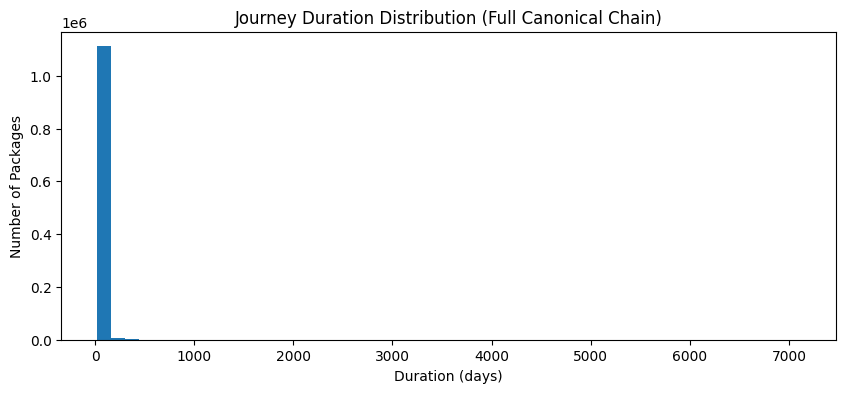

In [ ]:
# Assumes full_chain_mask, df are already defined as before

# Filtered DataFrame: only packages with full canonical chain
full_chain_ids = package_events[package_events.apply(lambda evs: chain_in_events(FULL_CHAIN, evs))].index
full_chain_df = df[df['MAILITM_FID'].isin(full_chain_ids)].copy()

# Compute duration per package
journey_times = (
    full_chain_df
    .groupby('MAILITM_FID')
    .agg(first_event=('date', 'min'), last_event=('date', 'max'))
)
journey_times['duration_days'] = (pd.to_datetime(journey_times['last_event']) - pd.to_datetime(journey_times['first_event'])).dt.total_seconds() / 86400

# Summary stats
print(journey_times['duration_days'].describe())

# Histogram plot (optional, if you have matplotlib/plotly)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.hist(journey_times['duration_days'], bins=50)
plt.title('Journey Duration Distribution (Full Canonical Chain)')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Packages')
plt.show()

In [ ]:
# Define your canonical sequence again for easy reference
canonical_events = FULL_CHAIN

# For segment durations:
segment_deltas = {f"{canonical_events[i]} ➔ {canonical_events[i+1]}": [] for i in range(len(canonical_events)-1)}

for mail_id, group in full_chain_df.groupby('MAILITM_FID'):
    events = group.sort_values('date')
    for i in range(len(canonical_events)-1):
        t1 = events.loc[events['EVENT_TYPE_NM'] == canonical_events[i], 'date']
        t2 = events.loc[events['EVENT_TYPE_NM'] == canonical_events[i+1], 'date']
        if not t1.empty and not t2.empty:
            delta = (pd.to_datetime(t2.values[0]) - pd.to_datetime(t1.values[0])).total_seconds()/86400
            segment_deltas[f"{canonical_events[i]} ➔ {canonical_events[i+1]}"].append(delta)

# Print stats for each segment
for k,v in segment_deltas.items():
    print(f"\n--- {k} ---")
    print(pd.Series(v).describe())



--- Réception d'envoi du client (Srt) ➔ Insérer envoi dans sac (Srt) ---
count    1.119440e+06
mean     3.375920e+00
std      4.383927e+00
min     -1.191329e+03
25%      4.125000e-01
50%      2.575000e+00
75%      5.554167e+00
max      6.721806e+02
dtype: float64

--- Insérer envoi dans sac (Srt) ➔ Expédition d'envoi à l'étranger (EDI-reçu) ---
count    1.119440e+06
mean     1.473883e+00
std      2.412288e+00
min     -3.492722e+02
25%      8.583333e-01
50%      1.221528e+00
75%      1.946528e+00
max      1.195280e+03
dtype: float64

--- Expédition d'envoi à l'étranger (EDI-reçu) ➔ Recevoir envoi au bureau d'échange (Ent) ---
count    1.119440e+06
mean     1.445522e+01
std      1.526316e+01
min     -1.959155e+03
25%      5.799129e+00
50%      9.753009e+00
75%      1.650302e+01
max      4.657711e+02
dtype: float64

--- Recevoir envoi au bureau d'échange (Ent) ➔ Expédier envoi à adresse nationale (Ent) ---
count    1.119440e+06
mean     1.201914e+00
std      1.106772e+01
min     -7.10833

In [ ]:
# Exchange office stats
exchange_stats = (
    full_chain_df[full_chain_df['EVENT_TYPE_NM'] == "Recevoir envoi au bureau d'échange (Ent)"]
    ['établissement_postal'].value_counts().head(10)
)
print("Top 10 Exchange Offices in FULL Chain:")
print(exchange_stats)

# Delivery office stats
delivery_stats = (
    full_chain_df[full_chain_df['EVENT_TYPE_NM'] == "Recevoir envoi au bureau de livraison (Ent)"]
    ['établissement_postal'].value_counts().head(10)
)
print("Top 10 Delivery Offices in FULL Chain:")
print(delivery_stats)


Top 10 Exchange Offices in FULL Chain:
établissement_postal
ALGER GARE             922955
ALGER COLIS POSTAUX    222238
ORAN EL M-NAOUER         5557
CONSTANTINE GARE         3849
ANNABA EL MARSA          3726
Name: count, dtype: int64
Top 10 Delivery Offices in FULL Chain:
établissement_postal
ANNABA EL MARSA              128283
CONSTANTINE COLIS POSTAUX    128155
CTR CHLEF                    102597
CDD SETIF                     92960
CDD BATNA                     45417
CDD SKIKDA                    44065
CDD JIJEL                     38997
CDD TLEMCEN                   33536
CDD BEJAIA                    32463
CDD TIZI-OUZOU                32208
Name: count, dtype: int64


In [ ]:
# Top 5 slowest journeys
slowest = journey_times.sort_values('duration_days', ascending=False).head(5)
print("Slowest FULL Chain Packages:")
print(slowest)

# Top 5 fastest journeys
fastest = journey_times.sort_values('duration_days').head(5)
print("Fastest FULL Chain Packages:")
print(fastest)


Slowest FULL Chain Packages:
                      first_event          last_event  duration_days
MAILITM_FID                                                         
RK853511820FR 2005-11-08 23:29:54 2025-05-08 07:40:04    7120.340394
RK526739733FR 2009-08-25 09:31:51 2023-10-18 08:05:54    5166.940312
RK526812685FR 2009-11-10 10:00:42 2023-02-04 10:17:16    4834.011505
RK651819793FR 2009-12-13 17:45:44 2022-07-31 12:00:41    4612.760382
RK853510634FR 2019-12-02 07:41:53 2025-04-26 08:09:23    1972.019097
Fastest FULL Chain Packages:
                      first_event          last_event  duration_days
MAILITM_FID                                                         
CP275800019PL 2023-03-20 12:50:00 2023-04-04 12:50:00      15.000000
RE040526903NL 2022-11-14 11:09:00 2022-11-29 11:09:00      15.000000
RU897563750NL 2022-03-19 11:24:00 2022-04-03 11:24:00      15.000000
RR017503877AE 2024-05-27 14:37:00 2024-06-11 14:37:01      15.000012
UY280663735CZ 2023-06-06 13:34:00 2023-06-21 

# 📦 Analysis of Packages with FULL Canonical Event Chain

## Overview

- **Total packages:** 1,119,440
- **Mean journey:** 37.2 days
- **Median journey:** 28.2 days
- **75th percentile:** 42.9 days
- **Std (spread):** 30.4 days
- **Max:** 7,120 days (clearly erroneous)

### Key Insight
Even among “perfect” journeys, there is significant delay in the international leg, and a *non-trivial number* of insane outliers (multi-year deliveries) indicating unclean data.

---

## Segment Analysis

| Segment                                               | Mean (days) | Median (days) | 25%   | 75%   | Max    | Notes                         |
|-------------------------------------------------------|-------------|--------------|-------|-------|--------|-------------------------------|
| Client Reception ➔ Bag Insert                         | 3.38        | 2.58         | 0.41  | 5.55  | 672    | Some huge/negative outliers   |
| Bag Insert ➔ Intl. Dispatch                          | 1.47        | 1.22         | 0.86  | 1.95  | 1,195  | Mostly quick, rare extremes   |
| Intl. Dispatch ➔ Local Exchange                      | 14.5        | 9.75         | 5.80  | 16.5  | 465    | Main delay: customs/transit   |
| Local Exchange ➔ National Dispatch                   | 1.20        | 0.08         | 0.03  | 0.92  | 2,529  | Almost always same day        |
| National Dispatch ➔ Delivery Office                  | 4.06        | 3.01         | 1.97  | 4.95  | 7,115  | Local transit, a few disasters|

---

## Top Offices

- **Exchange:** ALGER GARE, ALGER COLIS POSTAUX
- **Delivery:** ANNABA EL MARSA, CONSTANTINE COLIS POSTAUX, etc.

---

## Outliers

- **Slowest journey:** 7,120 days (bad data)
- **Fastest journey:** 15 days (theoretical minimum)

---

## Devil’s Recommendations

- **Clean the outliers:** Any package >1 year is likely garbage, filter before further stats.
- **Focus improvements** on customs/international transitions and busiest offices.
- **Median is your friend:** Use it for reporting “typical” times, not mean.
- **Review negative and gigantic deltas** — they always point to system or scanning issues.

---

*Ready to do the same with the “main delivered” and “main failed” event chains? Paste their stats next and let’s keep roasting!* 🔥


In [ ]:
# Ensure your dataframe is sorted by package and date
full_chain_df = full_chain_df.sort_values(['MAILITM_FID', 'date'])

# For each package, get the first and last event time
first_last = full_chain_df.groupby('MAILITM_FID')['date'].agg(['first', 'last'])
first_last['duration_days'] = (first_last['last'] - first_last['first']).dt.total_seconds() / 86400

# Merge duration back into your full_chain_df (if you want it everywhere), or just use first_last
full_chain_df = full_chain_df.merge(
    first_last['duration_days'],
    left_on='MAILITM_FID',
    right_index=True,
    how='left'
)

# Now your full_chain_df should have a 'duration_days' column!


In [ ]:
threshold = full_chain_df['duration_days'].quantile(0.80)
outliers_20pct_df = full_chain_df[full_chain_df['duration_days'] >= threshold]
print(outliers_20pct_df[['duration_days']].describe())


       duration_days
count   2.745187e+06
mean    8.191218e+01
std     4.987794e+01
min     5.031822e+01
25%     5.844174e+01
50%     7.002316e+01
75%     8.804229e+01
max     7.120340e+03


In [ ]:
# For outliers, get only delivery events
delivery_events = outliers_20pct_df[outliers_20pct_df['EVENT_TYPE_NM'] == "Recevoir envoi au bureau de livraison (Ent)"]

# Now count the most common delivery offices
top_offices = delivery_events['établissement_postal'].value_counts().head(10)
print("Top delivery offices among outliers:")
print(top_offices)


Top delivery offices among outliers:
établissement_postal
CONSTANTINE COLIS POSTAUX    32227
ANNABA EL MARSA              24881
CDD SETIF                    18816
CTR CHLEF                    18460
CDD BATNA                    10806
CDD BLIDA                     8350
CDD SKIKDA                    7946
CDD JIJEL                     7445
CDD TLEMCEN                   7202
CDD DJELFA                    6984
Name: count, dtype: int64


In [ ]:
# Get the last event for each slow package
last_events = outliers_20pct_df.sort_values(['MAILITM_FID', 'date']).groupby('MAILITM_FID').tail(1)

# Count by office
top_last_offices = last_events['établissement_postal'].value_counts().head(10)
print("Top offices for last event among outliers:")
print(top_last_offices)


Top offices for last event among outliers:
établissement_postal
ALGER COLIS POSTAUX    34142
ALGER GARE              6241
CDD TEBESSA              973
CDD MEDEA                972
REGHAIA                  761
CDD RELIZANE             715
CDD EL OUED              709
CHERIA-NEMEMCHA          631
CDD TLEMCEN              618
FRERES ACHOURI           568
Name: count, dtype: int64


In [ ]:
# Get the list of outlier package IDs
slow_pkg_ids = outliers_20pct_df.index if outliers_20pct_df.index.name == 'MAILITM_FID' else outliers_20pct_df['MAILITM_FID']

# Filter the main df for these packages and successful delivery events
last_success_df = df[
    (df['MAILITM_FID'].isin(slow_pkg_ids)) &
    (df['EVENT_TYPE_NM'] == "Livraison d'envoi (Ent)")
]

# Sort by package and date to get the last event
last_success_event = last_success_df.sort_values(['MAILITM_FID', 'date']).groupby('MAILITM_FID').tail(1)

# Count most common delivery offices
top_success_offices = last_success_event['établissement_postal'].value_counts().head(20)
print("Top delivery offices for last successful delivery among slowest 20%:")
print(top_success_offices)


Top delivery offices for last successful delivery among slowest 20%:
établissement_postal
CDD MEDEA              898
CDD TEBESSA            832
REGHAIA                710
CDD RELIZANE           710
CDD EL OUED            692
CHERIA-NEMEMCHA        596
CDD TLEMCEN            571
SETIF RP               531
TAHIR                  519
BIRKHADEM              518
CDD MILA               513
HARICHA                496
CDD AIN DEFLA          495
MEBARKI                489
CDD AIN MILILA         483
MOHAMMADIA             473
SKIKDA-FRERES-SAADI    460
LAKHDARIA              457
CDD GHARDAIA           450
AIN BENIAN             448
Name: count, dtype: int64


In [ ]:
# Merge duration info for context (optional, but fun)
examples = last_success_event.merge(
    outliers_20pct_df[['duration_days']],
    left_on='MAILITM_FID', right_index=True, how='left'
)
print(examples[['MAILITM_FID', 'date', 'établissement_postal', 'duration_days']].sort_values('duration_days', ascending=False).head(10))


ValueError: You are trying to merge on object and int64 columns for key 'MAILITM_FID'. If you wish to proceed you should use pd.concat